In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os,sys
from pathlib import Path
import json 
import logging
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.INFO)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)


#General ML 
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, silhouette_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

#In-house Module Imports
from config import Configuration 
from datasets import EclipseSampledDataset
from utils import *

from modules.models import BaseAutoencoder
from modules.models_helper import *

2.6.2


In [105]:
class Autoencoder(Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.params = params
        
        self.encoder = tf.keras.Sequential([
          #layers.Dropout(params['dropout']),                        
          #layers.Dense(1000, activation=params['hidden_acts']),
          layers.Dense(params['latent_dim'], activation=params['latent_activation'],name='code')
        ],name='Encoder')
        
        self.decoder = tf.keras.Sequential([
          #layers.Dense(1000, activation=params['hidden_acts']),                        
          #layers.Dropout(params['dropout']),                        
          layers.Dense(x_dim, activation='linear'),            
        ],name='Decoder')

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        return {
            "model_name": self.params['model_name'],
            #Layer related stuff
            "latent_dim": self.params['latent_dim'],
            "latent_activation": self.params['latent_activation'],
            "dropout_rate": self.params['dropout'],
            "regularizer": self.params['regularizer'],            
            "regularization_rate": self.params['regularization_rate'],                        
            #Compilation related stuff            
            "optimizer": self.optimizer,
            "loss": self.loss,
            #Training
            "epochs": self.params['epochs']
        }    

In [106]:
user = "aksar"
logging.warning(f'Are you sure that you are: {user}?')

2021-12-16 03:16:10,405 WARNING Are you sure that you are: aksar?


In [197]:
#Update these
CV_INDEX = 4
num_samples_per_pair = 5

In [198]:
#Update these if you are not the desired user
OUTPUT_DIR = f'/projectnb/peaclab-mon/{user}/clustering_experiments'
SYSTEM = 'eclipse'
EXP_NAME = 'comparison_experiments'
FEATURE_SELECTION = False
SCALER = 'None' #For now, do the scaling inside the notebook, then you can move that to the class function
MODEL_CONFIG = 'label_prop_and_cluster_then_predict_test'
logging.warning('Results will be generated in {}, double check please!'.format(MODEL_CONFIG))

2021-12-16 03:26:44,161 WARNING Results will be generated in label_prop_and_cluster_then_predict_test, double check please!


In [199]:
conf = Configuration(ipython=True,
                     overrides={
                         'output_dir': Path(OUTPUT_DIR), #change
                         'system' : SYSTEM,
                         'exp_name':EXP_NAME,                                                  
                         'cv_fold':CV_INDEX, 
                         'model_config': MODEL_CONFIG,
                     })

with open(str(conf['experiment_dir']) + '/anom_dict.json') as f:
    ANOM_DICT = json.load(f)
with open(str(conf['experiment_dir']) + '/app_dict.json') as f:
    APP_DICT = json.load(f)    
    
APP_REVERSE_DICT = {}
for app_name, app_encoding in APP_DICT.items():
    APP_REVERSE_DICT[app_encoding] = app_name    

ANOM_REVERSE_DICT = {}
for anom_name, anom_encoding in ANOM_DICT.items():
    ANOM_REVERSE_DICT[anom_encoding] = anom_name        

2021-12-16 03:26:44,223 WARNING You set windowing False, but you are trying to define window_size parameter, it is automatically set to 0. Please double check.
2021-12-16 03:26:44,224 INFO    Setting directory names
2021-12-16 03:26:44,226 INFO    Model config folder already exists, be careful, otherwise it will overwrite!
2021-12-16 03:26:44,227 INFO    Saving configuration as CSV


# The configuration used for this run:
# {'cv_fold': 4,
#  'exp_name': 'comparison_experiments',
#  'experiment_dir': PosixPath('/projectnb/peaclab-mon/aksar/clustering_experiments/eclipse/comparison_experiments'),
#  'feature_extract': False,
#  'feature_select': False,
#  'hdf_data_path': PosixPath('/projectnb/peaclab-mon/aksar/datasets/eclipse_sampled_hdfs'),
#  'metadata_path': None,
#  'model_config': 'label_prop_and_cluster_then_predict_test',
#  'model_config_dir': PosixPath('/projectnb/peaclab-mon/aksar/clustering_experiments/eclipse/comparison_experiments/CV_4/label_prop_and_cluster_then_predict_test'),
#  'model_dir': PosixPath('/projectnb/peaclab-mon/aksar/clustering_experiments/eclipse/comparison_experiments/CV_4/label_prop_and_cluster_then_predict_test/model'),
#  'num_split': 5,
#  'operation': 'read',
#  'output_dir': PosixPath('/projectnb/peaclab-mon/aksar/clustering_experiments/eclipse'),
#  'plots_dir': PosixPath('/projectnb/peaclab-mon/aksar/clustering_experiments/ec

In [200]:
eclipseDataset = EclipseSampledDataset(conf)
train_data, train_label, test_data, test_label = eclipseDataset.load_dataset(scaler=SCALER,borghesi=False)
assert list(train_data.index) == list(train_label.index) #check the order of the labels     
assert list(test_data.index) == list(test_label.index) #check the order of the labels    

if FEATURE_SELECTION:
    selected_features = pd.read_csv(conf['experiment_dir'] / 'selected_features.csv')
    train_data = train_data[list(selected_features['0'].values)]
    test_data = test_data[list(selected_features['0'].values)]

# all_data = pd.concat([train_data, test_data])
# all_label = pd.concat([train_label,test_label])

train_label['anom_names'] = train_label.apply(lambda x: ANOM_REVERSE_DICT[x['anom']], axis=1)
test_label['anom_names'] = test_label.apply(lambda x: ANOM_REVERSE_DICT[x['anom']], axis=1)

    
logging.info("Train data shape %s",train_data.shape)
logging.info("Train label shape %s",train_label.shape)
logging.info("Test data shape %s",test_data.shape)  
logging.info("Test label shape %s",test_label.shape)

logging.info("Train data label dist: \n%s",train_label['anom'].value_counts())
logging.info("Test data label dist: \n%s",test_label['anom'].value_counts())         

2021-12-16 03:26:44,296 INFO    BaseDataset Class Initialization
2021-12-16 03:26:44,297 INFO    HPCDataset Class Initialization
2021-12-16 03:26:44,298 INFO    EclipseSampledDataset Class Initialization
2021-12-16 03:26:44,642 INFO    Train data shape (1351, 1716)
2021-12-16 03:26:44,643 INFO    Train label shape (1351, 2)
2021-12-16 03:26:44,644 INFO    Test data shape (2462, 1716)
2021-12-16 03:26:44,644 INFO    Test label shape (2462, 2)
2021-12-16 03:26:44,646 WARNING Beware that no scaling method is applied
2021-12-16 03:26:44,718 INFO    Train data shape (1351, 1716)
2021-12-16 03:26:44,719 INFO    Train label shape (1351, 3)
2021-12-16 03:26:44,720 INFO    Test data shape (2462, 1716)
2021-12-16 03:26:44,721 INFO    Test label shape (2462, 3)
2021-12-16 03:26:44,723 INFO    Train data label dist: 
0    1217
2      34
1      34
4      33
3      33
Name: anom, dtype: int64
2021-12-16 03:26:44,726 INFO    Test data label dist: 
1    542
2    542
3    539
4    536
0    303
Name: an

In [201]:
SCALER = 'MinMax'

if SCALER == 'MinMax':
    
    minmax_scaler = MinMaxScaler().fit(train_data)
    train_data = pd.DataFrame(minmax_scaler.transform(train_data),columns=train_data.columns,index=train_data.index)
    test_data = pd.DataFrame(minmax_scaler.transform(test_data),columns=test_data.columns,index=test_data.index)
    
elif SCALER == 'Standard':
    
    # Standardize data (per feature Z-normalization, i.e. zero-mean and unit variance)        
    scaler = StandardScaler().fit(train_data)
    train_data = pd.DataFrame(scaler.transform(train_data),columns=train_data.columns,index=train_data.index)
    test_data = pd.DataFrame(scaler.transform(test_data),columns=test_data.columns,index=test_data.index)  

In [202]:
lp_train_label = pd.read_csv(conf['experiment_dir'] / f'CV_{CV_INDEX}'/ f'lp_train_label_{num_samples_per_pair}.csv', index_col=['node_id'])
lp_test_label = pd.read_csv(conf['experiment_dir'] / f'CV_{CV_INDEX}'/ f'lp_test_label_{num_samples_per_pair}.csv', index_col=['node_id'])

node_indices_labeled = list(lp_train_label['anom'].index.values)

In [203]:
logging.info("Labeled data label dist: \n%s",lp_train_label['anom'].value_counts())
logging.info("Unlabeled data label dist: \n%s",lp_test_label['anom'].value_counts())         

2021-12-16 03:26:45,057 INFO    Labeled data label dist: 
2    34
1    34
4    33
3    33
0    30
Name: anom, dtype: int64
2021-12-16 03:26:45,061 INFO    Unlabeled data label dist: 
0    1187
2      34
1      34
4      33
3      33
Name: anom, dtype: int64


In [204]:
params = {}

#Compile related
params['model_name'] = f'dae_{num_samples_per_pair}'
params['loss'] = 'mse'

params['optimizer'] = 'adadelta'
params['learning_rate'] = 1e-3

#Layer related
params['dropout'] = 0 #This will add dropout after layers
params['regularizer'] = None
params['regularization_rate'] = None

params['hidden_layers'] = []
params['hidden_acts'] = 'relu'

params['latent_dim'] =  2000 
params['latent_activation'] = 'relu' #change the activation of the code layer


#Training related
params['epochs'] = 100


if params['optimizer'] == 'adam':
    opt = optimizers.Adam(learning_rate=params['learning_rate'])
elif params['optimizer'] == 'adadelta':
    opt = optimizers.Adadelta(learning_rate=params['learning_rate'])
elif params['optimizer'] == 'sgd':
    opt = optimizers.SGD(learning_rate=params['learning_rate'])


if params['loss'] == 'mse':
    selected_loss = losses.MeanSquaredError()
elif params['loss'] == 'mae':
    selected_loss = losses.MeanAbsoluteError()

In [205]:
logging.info("Train data shape %s",train_data.shape)
logging.info("Train label shape %s",train_label.shape)
logging.info("Test data shape %s",test_data.shape)  
logging.info("Test label shape %s",test_label.shape)

logging.info("Train data label dist: \n%s",train_label['anom'].value_counts())
logging.info("Test data label dist: \n%s",test_label['anom'].value_counts())  

2021-12-16 03:26:45,187 INFO    Train data shape (1351, 1716)
2021-12-16 03:26:45,188 INFO    Train label shape (1351, 3)
2021-12-16 03:26:45,189 INFO    Test data shape (2462, 1716)
2021-12-16 03:26:45,189 INFO    Test label shape (2462, 3)
2021-12-16 03:26:45,192 INFO    Train data label dist: 
0    1217
2      34
1      34
4      33
3      33
Name: anom, dtype: int64
2021-12-16 03:26:45,194 INFO    Test data label dist: 
1    542
2    542
3    539
4    536
0    303
Name: anom, dtype: int64


Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code (Dense)                 (1351, 2000)              3434000   
Total params: 3,434,000
Trainable params: 3,434,000
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (1351, 1716)              3433716   
Total params: 3,433,716
Trainable params: 3,433,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 1s 19ms/step - loss: 0.1187 - val_loss: 0.1185
Epoch 2/100
34/34 [==============================] - 1s 16ms/step - loss: 0.1175 - val_loss: 0.1176
Epoch 3/100
34/34 [==============================] - 1s 16ms/step - loss: 0.1163 - val

2021-12-16 03:27:42,810 INFO    Assets written to: /projectnb/peaclab-mon/aksar/clustering_experiments/eclipse/comparison_experiments/CV_4/label_prop_and_cluster_then_predict_test/model/dae_5/assets
2021-12-16 03:27:42,839 INFO    Model saved!


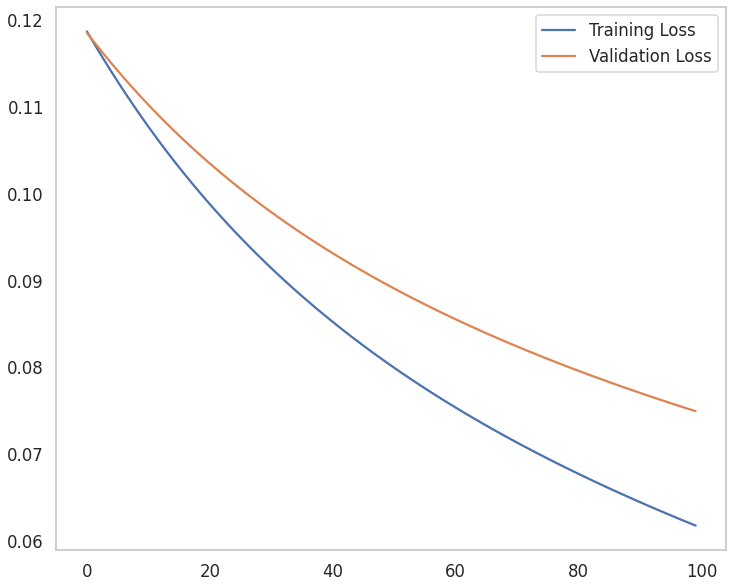

In [206]:
#BUILD AE

TRAIN_DATA = train_data.values

x_dim = TRAIN_DATA.shape[1]

autoencoder = Autoencoder(params)       

autoencoder.compile(optimizer=opt, loss=selected_loss)
autoencoder.build(TRAIN_DATA.shape) 
autoencoder.encoder.summary()
autoencoder.decoder.summary()
autoencoder.get_config()    

es = EarlyStopping(monitor='val_loss', 
                                    verbose=1,
                                    patience=10,
                                    mode='min',
                                    restore_best_weights=True)

history = autoencoder.fit(train_data.values, train_data.values,
                epochs=params['epochs'],
                shuffle=True,
                callbacks =[
                              es  
                            ],
                validation_split = 0.2,
                )

plt.plot(history.history["loss"], label="Training Loss")
if not history.history["val_loss"] is None:
    plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show

autoencoder.save(str(conf['model_dir'] / (params['model_name'])))
logging.info("Model saved!")    

### Train the supervised part

In [207]:
from sklearn.linear_model import LogisticRegression

In [208]:
def readModelConfig(exp_name,cv_index,model_name,system):
    """Reads saved config file and returns as a dictionary"""
    
    import math    
    config_path = Path('/projectnb/peaclab-mon/aksar/clustering_experiments/{system}/{exp_name}/CV_{cv_index}/{model_name}/model_config.csv'.format(system=system,exp_name=exp_name,cv_index=cv_index,model_name=model_name))
    conf = {}
    try:
        conf_csv = pd.read_csv(config_path)
    except:
        logging.info("Config.csv doesn't exist")
    

    for column in conf_csv.columns:
        if isinstance(conf_csv[column][0],str):
            if 'dir' in column:
                conf[column] = Path(conf_csv[column][0])
            else:
                conf[column] = conf_csv[column][0]
                
        #FIXME: Find a generic comparison for integers
        elif isinstance(conf_csv[column][0],np.int64):
                conf[column] = conf_csv[column][0]  
                
        elif isinstance(conf_csv[column][0],np.bool_):
                conf[column] = conf_csv[column][0]                  
        else:
            if math.isnan(conf_csv[column][0]):
                conf[column] = None
        
    return conf

In [209]:
def runMultipleTrainTestsProctorScikit(name,model_config,
                                       topology,X_train,y_train,X_test,y_test,
                                       repeat,cv_index,size,multimodal=True,stacked=False):
      
                                      
        macro_fscore = 0
        weight_fscore = 0
        miss_rate = 0
        alarm_rate = 0
        score_dict = {}
        
        #It means loading a full autoencoder
        if not stacked:
            reconstructedModel = LoadModel(model_config,topology)
            reconstructedModel = reconstructedModel.encoder
        else:
            reconstructedModel = LoadModel(model_config,topology)
                
        #Test data is constant 
        hidden_test = reconstructedModel.predict(X_test)             
                
        param_grid = {'C': [0.1,0.5, 1, 5, 10, 100, 1000],  
                      'tol': [1e-4, 1e-5, 1e-6,1e-7], 
                      'class_weight': [None, 'balanced'],
                      'max_iter': [1000,3000,5000,10000],
                      'penalty': ['l1','l2']
                      
                      }  
                    
        for i in range(repeat):                                    
            
            if multimodal:
                
                #Only anom vs normal            
                train_binary_label = y_train.copy()
                train_binary_label[train_binary_label != 0] = 1  
                                
                hidden_train_binary = reconstructedModel.predict(X_train)
                            
                
                ####Previous
                clf_binary = svm.LinearSVC(max_iter=10000,C=100)                 
                clf_binary.fit(hidden_train_binary, train_binary_label)                
                
                #Only anomalies
                anom_indices = np.where(y_train != 0)
                train_anom_label = y_train[anom_indices]
                train_anom_data = X_train[anom_indices]  
                
                hidden_train_anom = reconstructedModel.predict(train_anom_data)
                               
                clf_anom = svm.LinearSVC(max_iter=10000,C=100)    
                clf_anom.fit(hidden_train_anom, train_anom_label)                
                
                test_pred_label = filteredTestingProctorScikit(clf_binary,clf_anom,hidden_test)
            
            else:
                if name == 'aksar_svm':
                    hidden_train = reconstructedModel.predict(X_train)
                    clf = svm.LinearSVC(max_iter=10000,C=0.4)    
                    #clf = svm.LinearSVC()    
                    clf.fit(hidden_train, y_train)                            
                    test_pred_label = clf.predict(hidden_test)
                    
                elif name == 'aksar_lr':      
                    
                    hidden_train = reconstructedModel.predict(X_train)
                    clf = LogisticRegression(random_state=1234,
                                                    dual=True,
                                                    penalty='l2',
                                                    solver='liblinear')                      
                    clf.fit(hidden_train, y_train)                            
                    test_pred_label = clf.predict(hidden_test)
                    
                elif name == 'aksar_svm-scale':      
                    hidden_train = reconstructedModel.predict(X_train)
                    clf = svm.SVC(C=1,kernel='rbf',probability=True)
                    clf.fit(hidden_train, y_train)                            
                    test_pred_label = clf.predict(hidden_test)                                                                                             
            
            score_report = classification_report(y_true=y_test, y_pred =test_pred_label,output_dict=True)
            logging.info("#############")
            logging.info(classification_report(y_true=y_test, y_pred =test_pred_label))
            logging.info("#############")            
            alarm_report = falseAnomRateCalc(y_test,test_pred_label)
            
            macro_fscore += score_report['macro avg']['f1-score']            
            weight_fscore += score_report['weighted avg']['f1-score']
            miss_rate += alarm_report['anom_miss_rate'] 
            alarm_rate += alarm_report['false_alarm_rate']
        
        
        score_dict['false_alarm_rate'] = alarm_rate / repeat
        score_dict['anom_miss_rate'] = miss_rate / repeat        
        score_dict['macro_fscore'] = macro_fscore / repeat
        score_dict['weight_fscore'] = weight_fscore / repeat
        

        
        filename = f"test_Proctor-Kmeans-LogisticRegression-NoLP-NoTH_5_{size}_{cv_index}.json"
        json_dump = json.dumps(score_dict)
        f_json = open(model_config['results_dir'] / (filename),"w")
        f_json.write(json_dump)
        f_json.close() 

In [210]:
###Paper generation
MODEL_NAME = MODEL_CONFIG

SYSTEM = 'eclipse'

TOPOLOGY_NAME = f'dae_{num_samples_per_pair}'
STACKED = False #Set this when loading a stacked AE

FEATURE_SELECTION = False
REPEAT_SUPERVISED = 5
PERCENTAGE = 0

model_config = readModelConfig(exp_name=EXP_NAME,cv_index=CV_INDEX,model_name=MODEL_CONFIG,system=SYSTEM)

In [211]:
#Convert test data to array format
assert list(test_label.index) == list(test_data.index.get_level_values('node_id')) 
test_true_data = test_data.values 
#test_true_data_fs = test_data[list(selected_features['0'].values)] 
test_true_label = test_label['anom'].values 

#Training data with feature selection
#train_data_fs = train_data[list(selected_features['0'].values)]
X_DIM = train_data.shape[1]

In [212]:
train_semisup_data = train_data.loc[lp_train_label.index]
train_semisup_label = lp_train_label['anom'].values

In [213]:
logging.info("NO Feature selected data shape %s",train_semisup_data.shape) 

logging.info("Train data Anom label dist: \n%s",pd.DataFrame(train_semisup_label)[0].value_counts())
logging.info("Test data Anom label dist: \n%s",test_label['anom'].value_counts())  

2021-12-16 03:27:43,614 INFO    NO Feature selected data shape (164, 1716)
2021-12-16 03:27:43,617 INFO    Train data Anom label dist: 
2    34
1    34
4    33
3    33
0    30
Name: 0, dtype: int64
2021-12-16 03:27:43,619 INFO    Test data Anom label dist: 
1    542
2    542
3    539
4    536
0    303
Name: anom, dtype: int64


In [214]:
runMultipleTrainTestsProctorScikit(      
                    'aksar_lr',
                    model_config,
                    TOPOLOGY_NAME,
                    train_semisup_data,
                    train_semisup_label,
                    test_true_data,
                    test_true_label,
                    REPEAT_SUPERVISED,
                    CV_INDEX,
                    num_samples_per_pair,                    
                    multimodal=False, 
                    stacked=STACKED)       

2021-12-16 03:27:43,679 INFO    Loading model!
/project/peaclab-mon/monitoring_venv/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
2021-12-16 03:27:44,522 INFO    #############
2021-12-16 03:27:44,531 INFO                  precision    recall  f1-score   support

           0       0.86      0.98      0.92       303
           1       0.77      0.57      0.66       542
           2       0.47      0.59      0.52       542
           3       0.45      0.45      0.45       539
           4       0.98      0.92      0.95       536

    accuracy                           0.68      2462
   macro avg       0.71      0.70      0.70      2462
weighted avg       0.69      0.68      0.68      2462

2021-12-16 03:27:44,532 INFO    #############
2021-12-16 03:27:44,533 INFO    Total misclassified normal runs: 6, Total normal runs 303 
2021-12-16 03:27:44,53